## Blur and anonymize faces with OpenCV and Python - PyImage Search by Adrian Rosebrock

Source: https://www.pyimagesearch.com/2020/04/06/blur-and-anonymize-faces-with-opencv-and-python/

In this tutorial, we learn how to blur and anonymize faces using OpenCV and Python. Practical applications of this include:

- Privacy and identity protection in public/private areas
- Protecting children online 
- Photo journalism and news reporting (e.g., blur faces of people who did not sign a waiver form)
- Dataset curation and distribution (e.g., anonymize individuals in dataset)
 And more...
 
Key Take-aways:
- 4 steps to perform face blurring and anonymization:
    - Perform Face Detection
    - Extract face ROI (Region of Interest)
    - Store blurred face in original image
    - Blur/anonymize face
- Face Detector used is a deep learning-based Caffe model.

In [11]:
# Import Relevant Libraries

import numpy as np
import cv2
import os
import argparse
import matplotlib.pyplot as plt
from imutils.video import VideoStream
import imutils
import time


First we define helper functions `anonymize_face_simple` and `anonymize_face_pixelate` to perform the Guassian blur and pixelated blur-like effect respectively on the face ROI.

In [2]:
# Define helper functions

# Function to create Guassian Blur
def anonymize_face_simple(image, factor=3.0):
    
    # Automatically determine the size of the blurring kernel based
    # on the spatial dimensions of the input image
    (h, w) = image.shape[:2]
    kW = int(w / factor)
    kH = int(h / factor)
    
    # Ensure the width of the kernel is odd
    if kW % 2 == 0:
        kW += 1        
        
    # Ensure the height of the kernel is odd
    if kH % 2 == 0:
        kH += 1
        
    # Apply a Guassian blur to the input image using our computed
    # kernel size
    return cv2.GaussianBlur(image, (kW, kH), 0)

# Function for Pixelated blur-like effect
def anonymize_face_pixelate(image, blocks=3):
    
    # Divide the input image into NxN blocks
    (h, w) = image.shape[:2]
    x_steps = np.linspace(0, w, blocks + 1, dtype='int')
    y_steps = np.linspace(0, h, blocks + 1, dtype='int')
    
    # Loop over the blocks in both the x and y direction
    for i in range(1, len(y_steps)):
        for j in range(1, len(x_steps)):
            
            # Compute the starting and ending (x, y)-coordinates
            # for the current block
            start_x = x_steps[j - 1]
            start_y = y_steps[i - 1]
            end_x = x_steps[j]
            end_y = y_steps[i]
            
            # Extract the ROI using Numpy array slicing, compute the
            # mean of the ROI, and then draw a rectangle with the 
            # mean RGB values over the ROI in the original image
            roi = image[start_y:end_y, start_x:end_x]
            (B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]
            cv2.rectangle(image, (start_x, start_y), (end_x, end_y),
                         (B, G, R), -1)
            
    # Return the pixelated blurred image
    return image

We're ready to perform face detection.

In [7]:
# Load and Serialize face detector model from disk
def face_detectandblur(image, method):
    
    print("[INFO] Loading face detector model")
    prototext_path = "face_detector/deploy.prototxt"
    weights_path = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"
    
    net = cv2.dnn.readNet(prototext_path, weights_path)
    
    # Load the input image, clone it, and get spatial dimensions.
    image = cv2.imread(image)
    orig = image.copy()
    (h, w) = image.shape[:2]
    
    # Construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
                                (104.0, 177.0, 123.0))
    
    # STEP 1
    # Pass the blob through the network and obtain face detection
    print("[INFO] Computing face detections...")
    net.setInput(blob)
    detections = net.forward()
    
    # STEP 2
    # Loop over the detections
    for i in range(0, detections.shape[2]):
        # Extract confidence associated with detection
        confidence = detections[0, 0, i, 2]
        
        # Filter the weak detections by ensuring the confidence is
        # greater than the minimum confidence.
        if confidence > 0.5:
            # Compute the (x, y) coords of the bounding box for the 
            # object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (start_x, start_y, end_x, end_y) = box.astype("int")
            
            # Extract the face ROI
            face = image[start_y:end_y, start_x:end_x]
            
            # STEP 3
            # Check to see if we are applying "simple" face blurring
            # method
            
            if method == "simple":
                face = anonymize_face_simple(face, factor=3.0)
                
            # Apply pixelated
            else:
                face = anonymize_face_pixelate(face, blocks=20)
            
            # STEP 4
            # Store the blurred face in the output image
            image[start_y:end_y, start_x:end_x] = face
            
    
    # Display the original image and output with blurred face(s)
    # side by side
    output = np.hstack([orig, image])
    #cv2.imshow("Output", output)
    plt.imshow(output)
    cv2.waitKey(0)
 

[INFO] Loading face detector model
[INFO] Computing face detections...


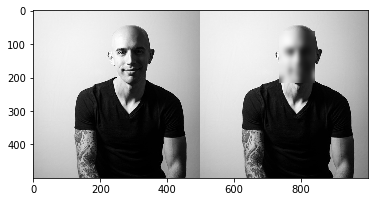

In [8]:
face_detectandblur("examples/adrian.jpg", "simple")

[INFO] Loading face detector model
[INFO] Computing face detections...


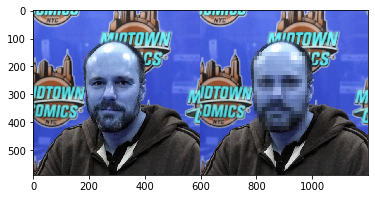

In [9]:
face_detectandblur("examples/tom_king.jpg", "pixelated")

[INFO] Loading face detector model
[INFO] Computing face detections...


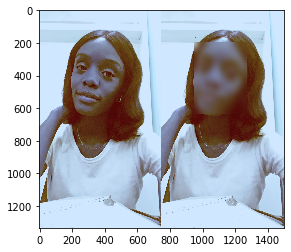

In [10]:
face_detectandblur("examples/mofe.jpg", "simple")

### Implementing Blurring on real-time video with OpenCV

In [12]:

def realtime_blur(method):
    
    # Load serialized face detector model
    print("[INFO] Loading face detector model...")
    prototxt_path = "face_detector/deploy.prototxt"
    weights_path = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"

    net = cv2.dnn.readNet(prototxt_path, weights_path)

    # Initialize video stream and allow camera sensor to warm up
    print("[INFO] Starting video stream...")
    vs = VideoStream(src=0).start()
    time.sleep(2.0)

    # Loop over frames from the video stream
    while True:

        # Grab frame and resize to have a maximum size of 400 pixels
        frame = vs.read()
        frame = imutils.resize(frame, width=400)

        # Construct a blob from dimensions of the frame
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                    (104.0, 177.0, 123.0))

        # Pass blob through the network and obtain detections
        net.setInput(blob)
        detections = net.forward()
        
        # Loop over detections
        for i in range(0, detections.shape[2]):
            
            # Extract confidence
            confidence = detections[0, 0, i, 2]
            
            # Filter weak confidences
            if confidence > 0.6:
                
                # Compute x,y coords of the bounding boxes
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (start_x, start_y, end_x, end_y) = box.astype(int)
                
                # Extract frame ROI
                face = frame[start_y:end_y, start_x:end_x]
                
                # Applying blurring method
                if method == "simple":
                    face = anonymize_face_simple(face, factor=3.0)
                    
                else:
                    face = anonymize_face_pixelate(face, blocks=20)
                    
                # Store blurred face in output
                frame[start_y:end_y, start_x:end_x] = face
                
        # Show the output frame
        plt.imshow(frame)
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        
        # break if q is pressed
        if key == ord("q"):
            break
            
    cv2.destroyAllWindows()
    vs.stop()   

[INFO] Loading face detector model...
[INFO] Starting video stream...


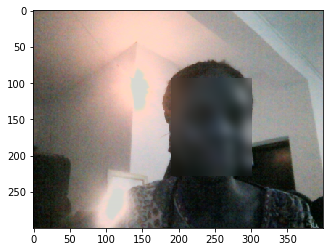

In [14]:
realtime_blur("simple")

[INFO] Loading face detector model...
[INFO] Starting video stream...


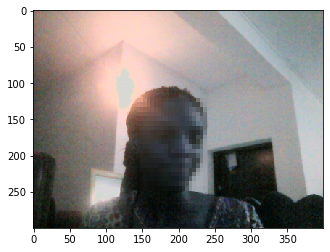

In [15]:
realtime_blur("pixelated")

#### Amazing!!!!!!!!!!!!!!!